# parallel MLD

并行的最大似然解码器，其中调用MLD模块函数，以及spped_up_mld.ipynb中的函数。

分析超图的结构

我们考虑两个示例：
* d=3，r=1的示例。
* d=3，r=3的示例。

## d=3, r=1 示例

In [53]:
from MLD import MaxLikelihoodDecoder
import stim

circuit_noisy = stim.Circuit.from_file("./data/surface_code_bZ_d3_r01_center_3_5/circuit_noisy.stim")
detector_error_model = circuit_noisy.detector_error_model()

ml_decoder = MaxLikelihoodDecoder(detector_error_model, detector_error_model.num_detectors)
# 计算每个节点的相邻节点
detector_connectivity = ml_decoder.compute_detector_connectivity(have_logical_observable=False)

查看detector_connectivity的图形化表示。

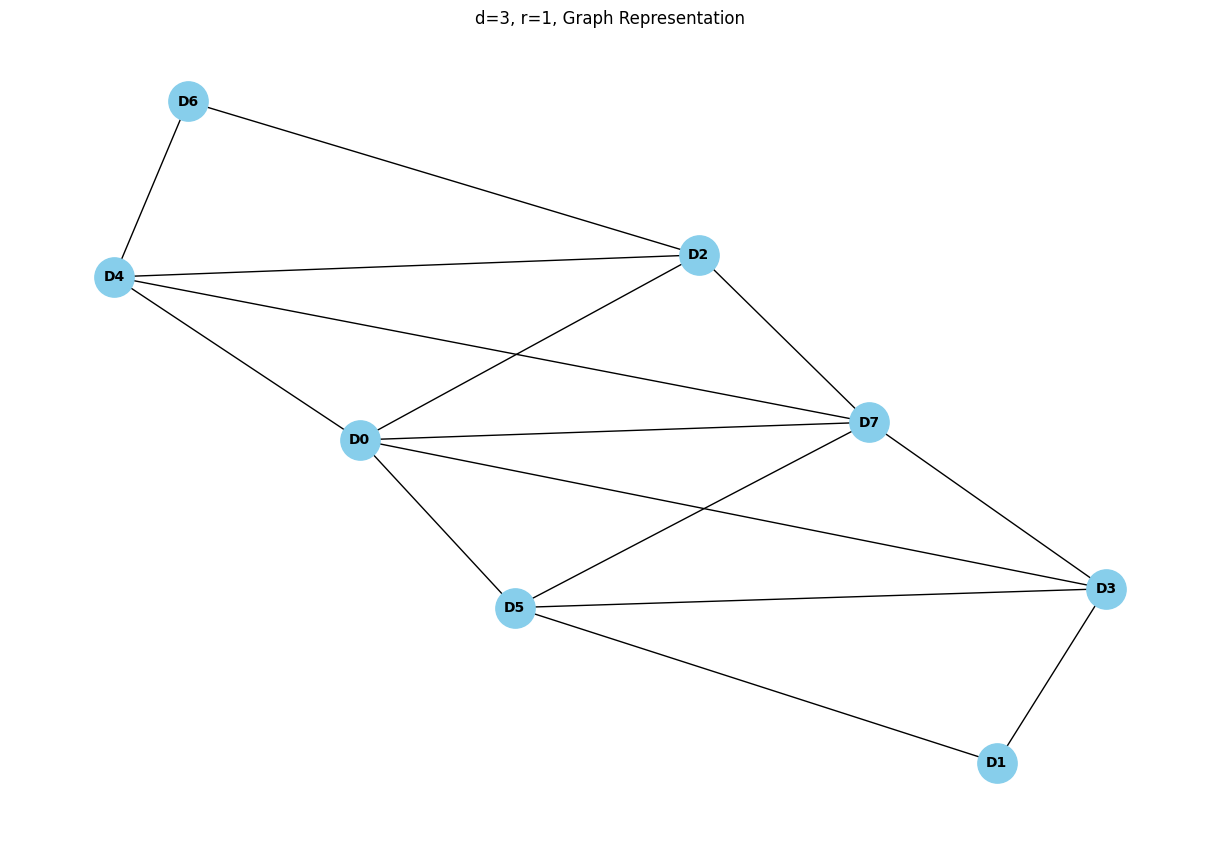

In [54]:
import logging
import matplotlib as mpl

# 设置matplotlib的日志级别为WARNING
mpl.set_loglevel('WARNING')

# 设置全局日志级别为 WARNING
logging.basicConfig(level=logging.WARNING)

import networkx as nx
import matplotlib.pyplot as plt

# 定义邻接列表
edges = detector_connectivity

# 创建图
G = nx.Graph()

# 添加边
for node, neighbors in edges.items():
    for neighbor in neighbors:
        G.add_edge(node, f'D{neighbor}')

# 绘制图
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # 使用弹簧布局
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('d=3, r=1, Graph Representation')
plt.show()

[[0, 1, 6], [2, 3], [4, 5], [7]]

我们可以从非detector_connectivity["D0"]中，选择其中一个作为不相邻的detector来并行执行。

不相邻的节点有很多，我们暂时按照顺序，选择最小序号的detector作为并行执行的节点。

可能的选择策略：
* 选择序号最小的节点。
* 选择相邻节点数最小，同时序号最小。
* 选择连接的边数最小，同时序号最小。

我们暂时先考虑最简单的策略，即第一种序号最小。

In [55]:
def min_index_parallel_detectors_method(detector_number, detector_connectivity):
    
    each_step_parallel_detector = []
    
    current_parallel_detector_candidates = list(range(detector_number))
    unexecuted_detectors = list(range(detector_number))
    # 轮次
    num_steps = 0
    while unexecuted_detectors:
        # 多轮进行并行执行：
        # print(f"--------------第{num_steps}轮--------------------")
        # 初始化list
        current_parallel_detector_candidates = unexecuted_detectors.copy()
        current_parallel_detectors = []
        
        while current_parallel_detector_candidates:
            detector = current_parallel_detector_candidates.pop(0)
            current_parallel_detectors.append(detector)
            unexecuted_detectors.remove(detector)

            # 更新current_parallel_detector_candidates，找到所有与current_parallel_detectors不相邻的节点。
            current_parallel_detector_candidates = [i for i in current_parallel_detector_candidates if i not in detector_connectivity[f"D{detector}"]]
            # print(f"当前并行执行的节点: {detector}")
            connected_detector = detector_connectivity[f"D{detector}"]
            # print(f"当前相邻节点: {connected_detector}, 相邻节点数：{len(connected_detector)}")
            # print("后续可以选择的非相邻可并行节点",current_parallel_detector_candidates)
            # print("当前未执行的节点", unexecuted_detectors)
            
        num_steps += 1
        each_step_parallel_detector.append(current_parallel_detectors)
        print(f"--------------第{num_steps}轮执行的节点: {current_parallel_detectors}------------")
    return num_steps, each_step_parallel_detector

num_steps, each_step_parallel_detector = min_index_parallel_detectors_method(ml_decoder.detector_number, detector_connectivity)
print(f"共执行了{num_steps}轮, 每列执行的节点应该为：{each_step_parallel_detector}")

--------------第1轮执行的节点: [0, 1, 6]------------
--------------第2轮执行的节点: [2, 3]------------
--------------第3轮执行的节点: [4, 5]------------
--------------第4轮执行的节点: [7]------------
共执行了4轮, 每列执行的节点应该为：[[0, 1, 6], [2, 3], [4, 5], [7]]


我们能否可视化下面的超图？

In [56]:
detector_error_model

stim.DetectorErrorModel('''
    error(0.009889) D0 D2
    error(0.00341035) D0 D3
    error(0.0329122) D0 D4
    error(0.00433956) D0 D5
    error(0.00921673) D0 D7
    error(0.0145061) D0 L0
    error(0.00400415) D1 D3
    error(0.0299506) D1 D5
    error(0.00278521) D1 L0
    error(0.00965131) D2
    error(0.00488075) D2 D4
    error(0.0252629) D2 D6
    error(0.00467753) D2 D7
    error(0.0176977) D3
    error(0.00325365) D3 D5
    error(0.0357146) D3 D7
    error(0.0139548) D4 D6
    error(0.0160334) D4 D7
    error(0.0626966) D4 L0
    error(0.0226447) D5 D7
    error(0.0197193) D5 L0
    error(0.0108271) D6
    error(0.0564801) D7
    detector(2, 5, 0) D0
    detector(4, 3, 0) D1
    detector(2, 7, 0) D2
    detector(4, 5, 0) D3
    detector(2, 5, 1) D4
    detector(4, 3, 1) D5
    detector(2, 7, 1) D6
    detector(4, 5, 1) D7
''')

定义一个超图类

In [57]:
from MLD_Hypergraph import MLD_Hypergraph

In [58]:
mld_hypergraph = MLD_Hypergraph(detector_error_model=detector_error_model)

### 利用二部图，可视化超图。

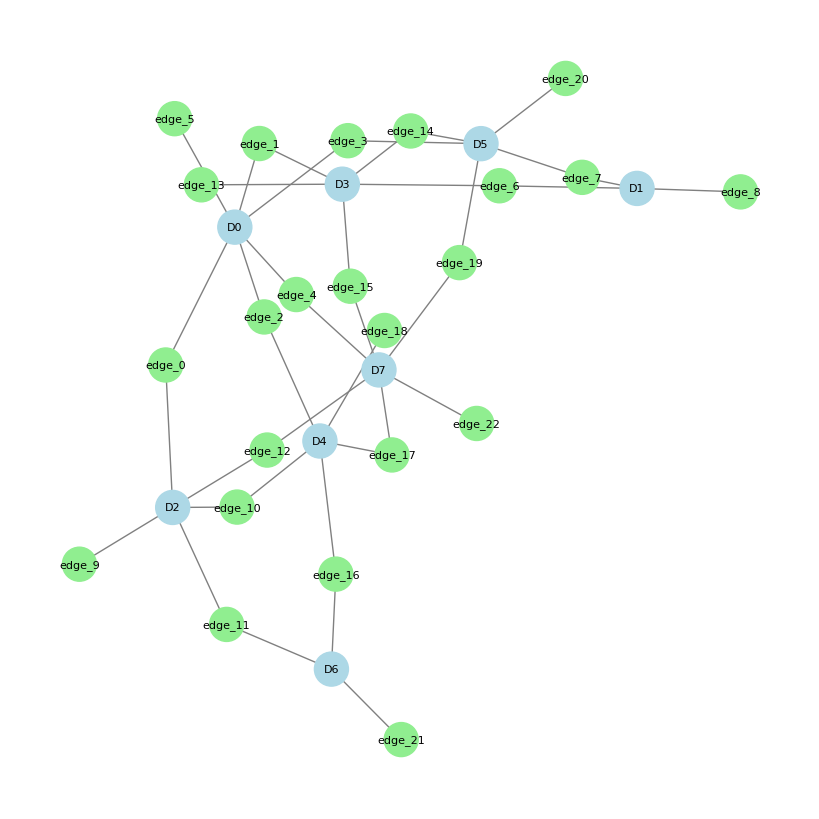

In [59]:
mld_hypergraph.draw_bipartite_graph()

### hypernetx可视化
尝试使用hypernetx画超图，具体使用参考：https://hypernetx.readthedocs.io/en/develop/classes/classes.html#classes.HypergraphView.default_weight

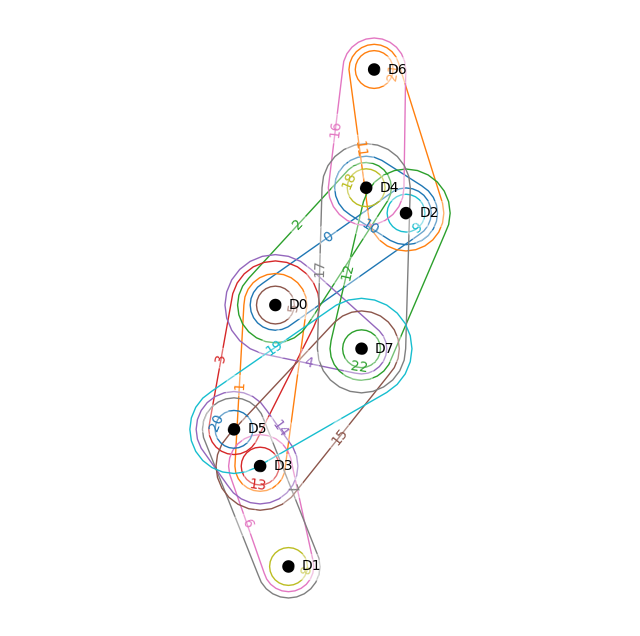

In [60]:
import hypernetx as hnx
# import matplotlib.pyplot as plt

H = mld_hypergraph.to_hypernetx_hypergraph()
# # 可视化超图
hnx.draw(H)
plt.show()

### 考虑具体的并行分析

共执行了4轮, 每列执行的节点应该为：[[0, 1, 6], [2, 3], [4, 5], [7]]
存在的边为：

    error(0.009889) D0 D2
    error(0.00341035) D0 D3
    error(0.0329122) D0 D4
    error(0.00433956) D0 D5
    error(0.00921673) D0 D7
    error(0.0145061) D0 L0
    error(0.00400415) D1 D3
    error(0.0299506) D1 D5
    error(0.00278521) D1 L0
    error(0.00965131) D2
    error(0.00488075) D2 D4
    error(0.0252629) D2 D6
    error(0.00467753) D2 D7
    error(0.0176977) D3
    error(0.00325365) D3 D5
    error(0.0357146) D3 D7
    error(0.0139548) D4 D6
    error(0.0160334) D4 D7
    error(0.0626966) D4 L0
    error(0.0226447) D5 D7
    error(0.0197193) D5 L0
    error(0.0108271) D6
    error(0.0564801) D7


第一轮，我们可以合并0、1、6的相关边。

首先，先实现一个取出与D0相关的所有边的index，根据index取出边和权重。
利用对应边的和权重，来计算分布。
输入还存在初始分布。

第二轮，计算2和3。
* 要剪枝2，我们需要用到1和6合并的分布。
* 要剪枝3，我们需要1和0的分布。

感觉任务划分不是上述的划分形式。

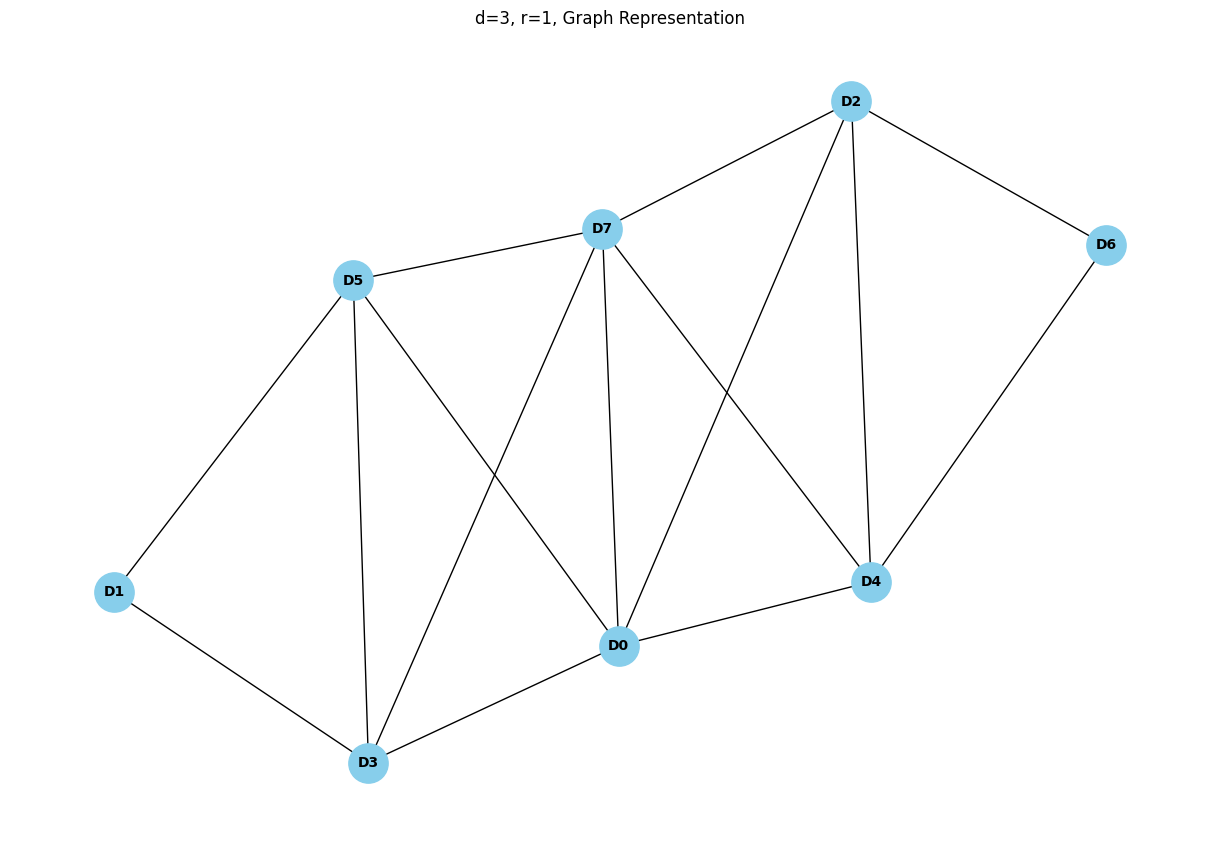

对于上述图像，我们考虑先执行D1和D6。
* 第二步，我们考虑执行D3和D2，因为D3和D2的相邻节点是D0和D1，而D0和D1已经执行了。对于处理器0而言，相当于，我们得到了D1和D3的确定分布，不确定的分布为$2^3$，即D5、D7、D0。另一个处理器类似。
* 第三步，我们考虑执行D4和D5，因为D4和D5的相邻节点是D0和D1，而D0和D1已经执行了。对于处理器0而言，相当于，我们得到了D1和D3和D5的确定分布，不确定的分布为$2^2$，即D7、D0。另一个处理器类似。
* 最后，我们只需要合并两个$2^3$的分布即可。

有比较明显的对称性。

## d=3，r=3的示例

In [61]:
from MLD import MaxLikelihoodDecoder
import stim

circuit_noisy = stim.Circuit.from_file("./data/surface_code_bZ_d3_r03_center_3_5/circuit_noisy.stim")
detector_error_model = circuit_noisy.detector_error_model()

ml_decoder = MaxLikelihoodDecoder(detector_error_model, detector_error_model.num_detectors)
# 计算每个节点的相邻节点
detector_connectivity = ml_decoder.compute_detector_connectivity(have_logical_observable=False)

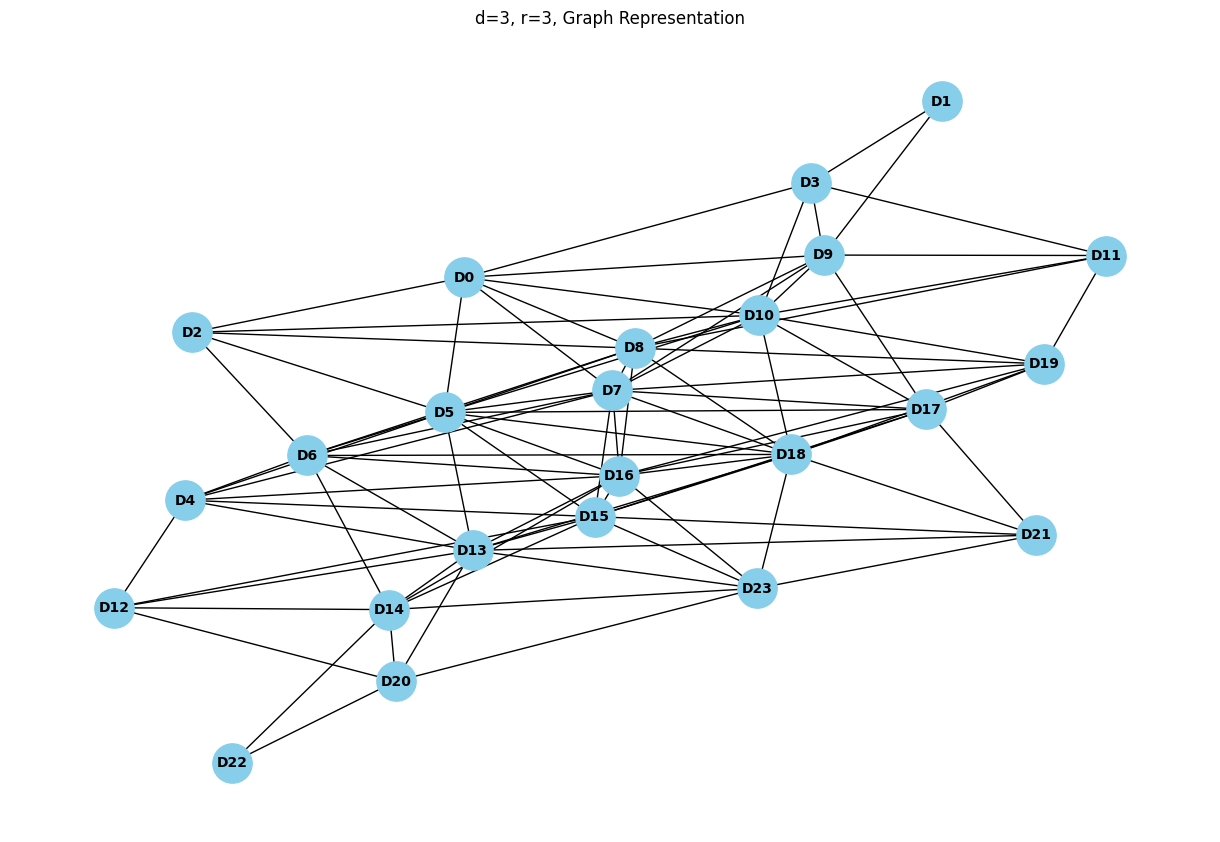

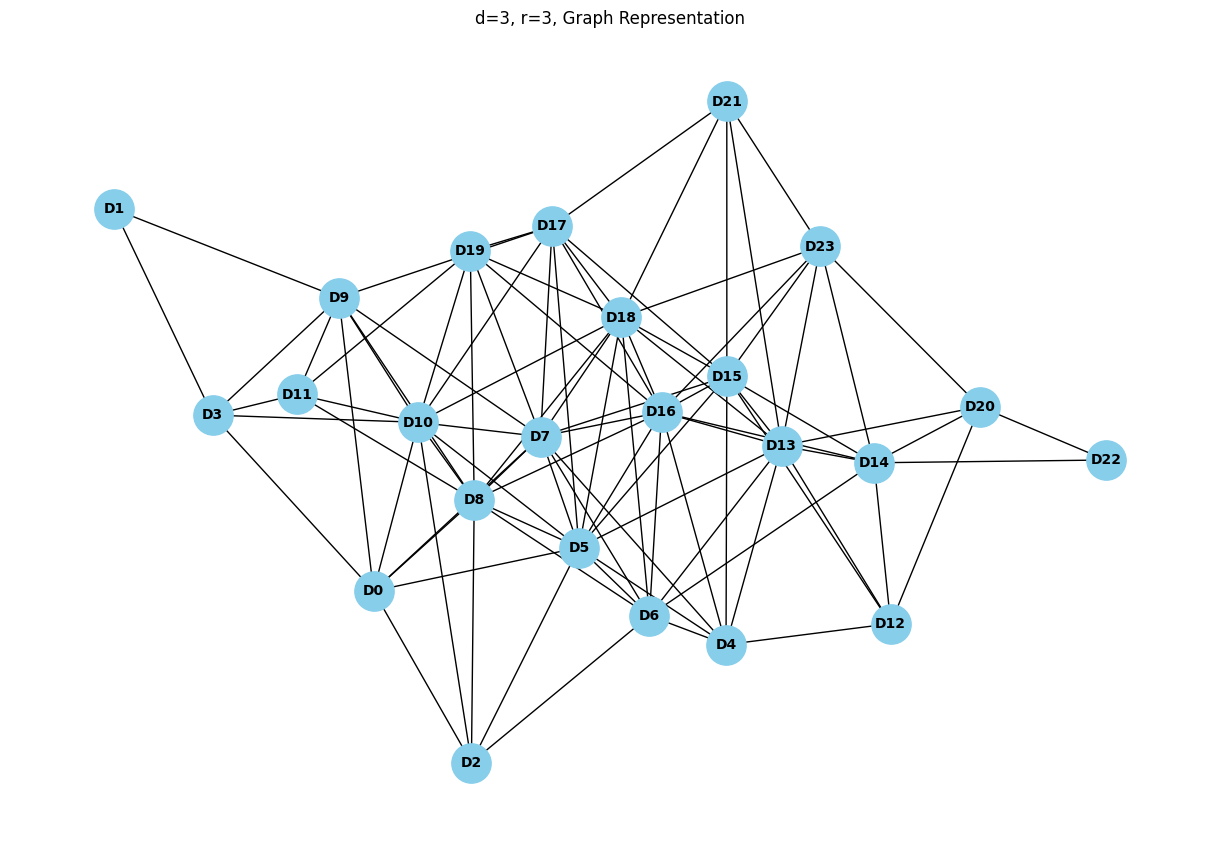

In [48]:
import logging
import matplotlib as mpl

# 设置matplotlib的日志级别为WARNING
mpl.set_loglevel('WARNING')

# 设置全局日志级别为 WARNING
logging.basicConfig(level=logging.WARNING)

import networkx as nx
import matplotlib.pyplot as plt

# 定义邻接列表
edges = detector_connectivity

# 创建图
G = nx.Graph()

# 添加边
for node, neighbors in edges.items():
    for neighbor in neighbors:
        G.add_edge(node, f'D{neighbor}')

# 绘制图
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G)  # 使用弹簧布局

# pos = nx.circular_layout(G)  # 使用环形布局,使用 circular_layout 来使图对称
# pos = nx.shell_layout(G,nlist=[[f'D{i}' for i in range(0,4)], [f'D{i}' for i in range(4,12)], [f'D{i}' for i in range(12,20)], [f'D{i}' for i in range(20,24)]])

# pos = nx.multipartite_layout(G, subset_key="group")

nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold')




# 绘制图
# nx.draw(
#     G, pos, with_labels=True, 
#     node_size=800, node_color='skyblue', 
#     edge_color='gray', font_size=10, 
#     font_weight='bold'
# )
plt.title('d=3, r=3, Graph Representation')
plt.show()

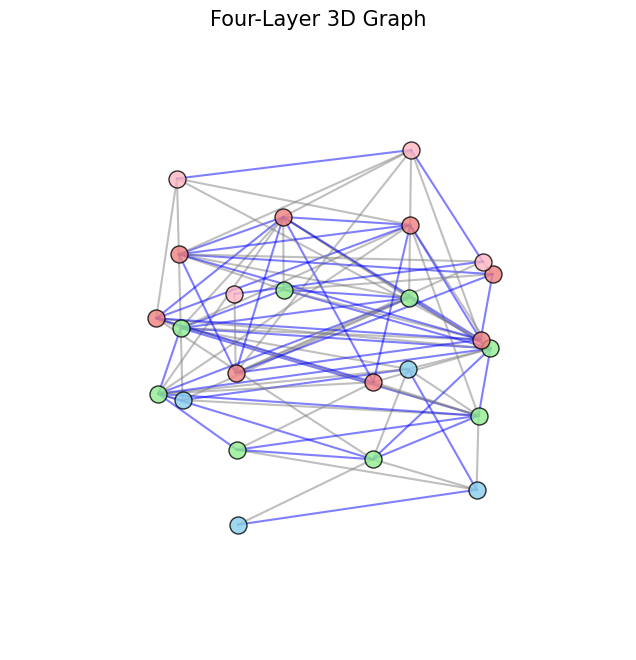

In [44]:
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

# 创建图
G = nx.Graph()

# 定义邻接列表
# detector_connectivity = 

# 添加边
for node, neighbors in detector_connectivity.items():
    for neighbor in neighbors:
        G.add_edge(node, f'D{neighbor}')

# 设置图的层次结构（每层的节点列表）
layers = [[f'D{i}' for i in range(0,4)], [f'D{i}' for i in range(4,12)], [f'D{i}' for i in range(12,20)], [f'D{i}' for i in range(20,24)]]

# 创建三维图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 记录节点的位置
pos = {}

# 不同层次的颜色
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink']

z_spacing = 30  # 每层的高度间隔

# 记录节点的位置
pos = {}

# 在每一层设置节点的位置
for z, layer in enumerate(layers):
    shell_pos = nx.shell_layout(G.subgraph(layer))  # 2D shell 布局
    
    # 添加 z 轴坐标，将节点放置在不同的平面上
    for node in layer:
        pos[node] = (shell_pos[node][0], shell_pos[node][1], z * z_spacing)
        ax.scatter(shell_pos[node][0], shell_pos[node][1], z * z_spacing, 
                   s=150, c=colors[z % len(colors)], edgecolor='k', alpha=0.8)

# 绘制边并设置透明度
for u, v in G.edges():
    x_values = [pos[u][0], pos[v][0]]
    y_values = [pos[u][1], pos[v][1]]
    z_values = [pos[u][2], pos[v][2]]
    
    color = 'gray'
    if pos[u][2] == pos[v][2]:  # 同一层次上的边用不同颜色
        color = 'blue'
    ax.plot(x_values, y_values, z_values, color=color, alpha=0.5)

# 设置图的标题
ax.set_title("Four-Layer 3D Graph", fontsize=15)
ax.view_init(elev=30, azim=30)  # 设置视角

# 隐藏背景网格
ax.grid(False)
ax.set_axis_off()

# 展示图形
plt.show()

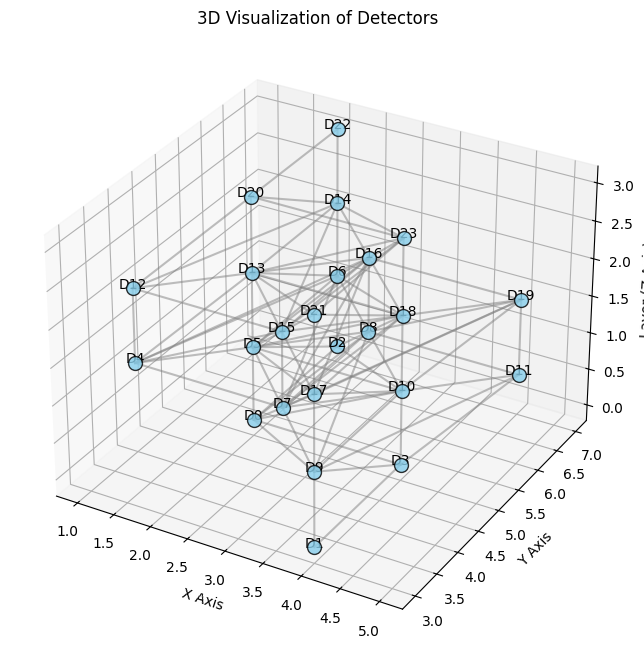

In [45]:
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

# 创建图
G = nx.Graph()

# 定义节点位置 (x, y, z)
detectors = {
    'D0': (2, 5, 0), 'D1': (4, 3, 0), 'D2': (2, 7, 0), 'D3': (4, 5, 0),
    'D4': (1, 4, 1), 'D5': (2, 5, 1), 'D6': (2, 7, 1), 'D7': (3, 4, 1),
    'D8': (3, 6, 1), 'D9': (4, 3, 1), 'D10': (4, 5, 1), 'D11': (5, 6, 1),
    'D12': (1, 4, 2), 'D13': (2, 5, 2), 'D14': (2, 7, 2), 'D15': (3, 4, 2),
    'D16': (3, 6, 2), 'D17': (4, 3, 2), 'D18': (4, 5, 2), 'D19': (5, 6, 2),
    'D20': (2, 5, 3), 'D21': (4, 3, 3), 'D22': (2, 7, 3), 'D23': (4, 5, 3)
}

# 添加节点
for node, (x, y, z) in detectors.items():
    G.add_node(node, pos=(x, y, z))
# 添加边
for node, neighbors in detector_connectivity.items():
    for neighbor in neighbors:
        G.add_edge(node, f'D{neighbor}')

pos = nx.get_node_attributes(G, 'pos')

# 创建三维图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制节点
for node, (x, y, z) in pos.items():
    ax.scatter(x, y, z, s=100, c='skyblue', edgecolor='k', alpha=0.8)
    ax.text(x, y, z, f'{node}', fontsize=10, ha='center')

# 绘制边
for u, v in G.edges():
    x_values = [pos[u][0], pos[v][0]]
    y_values = [pos[u][1], pos[v][1]]
    z_values = [pos[u][2], pos[v][2]]
    ax.plot(x_values, y_values, z_values, color='gray', alpha=0.5)

# 设置轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Layer (Z Axis)')

# 设置标题
ax.set_title('3D Visualization of Detectors')

# 显示图形
plt.show()

(0.0, 8.0)

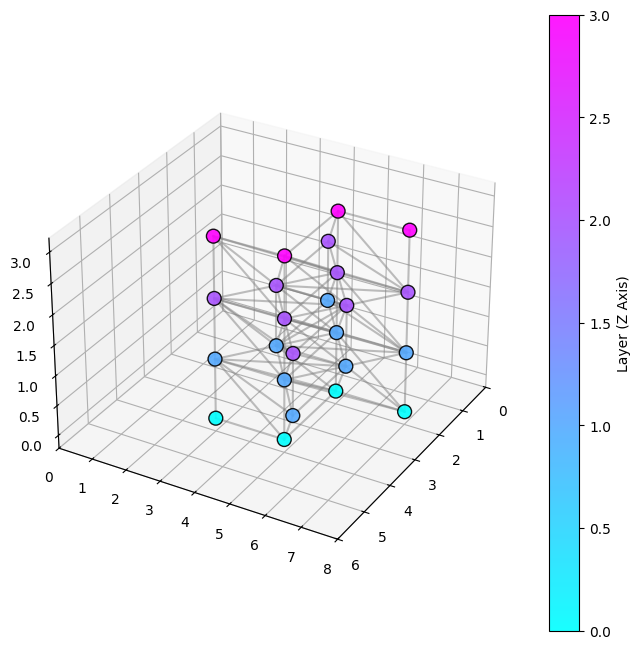

In [46]:
pos = nx.get_node_attributes(G, 'pos')

# 定义颜色映射，根据 z 值区分不同层
colors = [pos[node][2] for node in G.nodes()]

# 创建三维图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制节点（使用颜色区分层数）
sc = ax.scatter(
    [pos[node][0] for node in G.nodes()],
    [pos[node][1] for node in G.nodes()],
    [pos[node][2] for node in G.nodes()],
    c=colors, cmap='cool', s=100, edgecolor='k', alpha=0.9
)

# 添加颜色条
plt.colorbar(sc, ax=ax, label='Layer (Z Axis)')

# 绘制边
for u, v in G.edges():
    x_values = [pos[u][0], pos[v][0]]
    y_values = [pos[u][1], pos[v][1]]
    z_values = [pos[u][2], pos[v][2]]
    ax.plot(x_values, y_values, z_values, color='gray', alpha=0.5)

# 调整视角和坐标范围
ax.view_init(elev=30, azim=30)  # 调整视角
ax.set_xlim([0, 6])
ax.set_ylim([0, 8])

In [39]:
detector_connectivity

{'D0': [2, 8, 3, 5, 7, 9, 10],
 'D2': [0, 8, 5, 6, 10],
 'D8': [0, 2, 5, 7, 9, 10, 6, 16, 18, 11, 19],
 'D3': [0, 1, 9, 11, 10],
 'D5': [0, 7, 8, 2, 4, 6, 16, 13, 15, 10, 18, 17],
 'D7': [0, 5, 8, 9, 10, 4, 6, 16, 18, 15, 17, 19],
 'D9': [0, 7, 8, 1, 3, 11, 10, 17],
 'D10': [0, 7, 8, 2, 3, 11, 5, 9, 18, 17, 19],
 'D1': [3, 9],
 'D6': [2, 8, 4, 5, 16, 13, 7, 18, 14],
 'D11': [3, 9, 10, 8, 19],
 'D4': [5, 6, 16, 7, 13, 15, 12],
 'D16': [4, 5, 6, 13, 7, 8, 17, 18, 15, 14, 23, 19],
 'D13': [4, 5, 15, 16, 6, 12, 14, 20, 18, 23, 21],
 'D15': [4, 5, 13, 7, 17, 18, 16, 12, 14, 23, 21],
 'D12': [4, 13, 14, 15, 20],
 'D18': [5, 7, 8, 15, 16, 6, 10, 19, 17, 13, 23, 21],
 'D17': [5, 7, 15, 16, 9, 10, 19, 18, 21],
 'D14': [6, 16, 12, 13, 20, 15, 23, 22],
 'D19': [7, 10, 17, 18, 8, 11, 16],
 'D20': [12, 13, 14, 22, 23],
 'D23': [13, 15, 16, 14, 18, 21, 20],
 'D21': [13, 15, 17, 18, 23],
 'D22': [14, 20]}

In [24]:
# G# 获取邻接矩阵
# adj_matrix = nx.adjacency_matrix(G).todense()

# # 打印邻接矩阵
# print("邻接矩阵：")
# print(adj_matrix)
# import numpy as np
# def is_symmetric(adj_matrix):
#     # 判断邻接矩阵是否是对称的
#     return np.allclose(adj_matrix, adj_matrix.T)

# # 判断是否关于某个轴对称
# if is_symmetric(adj_matrix):
#     print("图是对称的")
# else:
#     print("图不是对称的")

## d=5, r=1示例

In [49]:
from MLD import MaxLikelihoodDecoder
import stim

circuit_noisy = stim.Circuit.from_file("./data/surface_code_bZ_d5_r01_center_5_5/circuit_noisy.stim")
detector_error_model = circuit_noisy.detector_error_model()

ml_decoder = MaxLikelihoodDecoder(detector_error_model, detector_error_model.num_detectors)
# 计算每个节点的相邻节点
detector_connectivity = ml_decoder.compute_detector_connectivity(have_logical_observable=False)

In [52]:
detector_error_model

stim.DetectorErrorModel('''
    error(0.009889) D0 D3
    error(0.00341035) D0 D4
    error(0.0329122) D0 D12
    error(0.00433956) D0 D13
    error(0.00921673) D0 D16
    error(0.0145061) D0 L0
    error(0.00903235) D1 D4
    error(0.0021719) D1 D5
    error(0.0314607) D1 D13
    error(0.00313864) D1 D14
    error(0.00694323) D1 D17
    error(0.00926813) D1 L0
    error(0.00492676) D2 D5
    error(0.0184619) D2 D14
    error(0.0029623) D2 L0
    error(0.00304868) D3 D6
    error(0.00488075) D3 D12
    error(0.0252629) D3 D15
    error(0.00467753) D3 D16
    error(0.00909811) D3 D18
    error(0.0090713) D4 D6
    error(0.00298924) D4 D7
    error(0.00325365) D4 D13
    error(0.0357146) D4 D16
    error(0.00348685) D4 D17
    error(0.00856605) D4 D19
    error(0.0178761) D5 D7
    error(0.00255512) D5 D8
    error(0.00420019) D5 D14
    error(0.0360415) D5 D17
    error(0.00673072) D5 D20
    error(0.00968751) D6 D9
    error(0.00208549) D6 D10
    error(0.00378452) D6 D16
    error(0.0

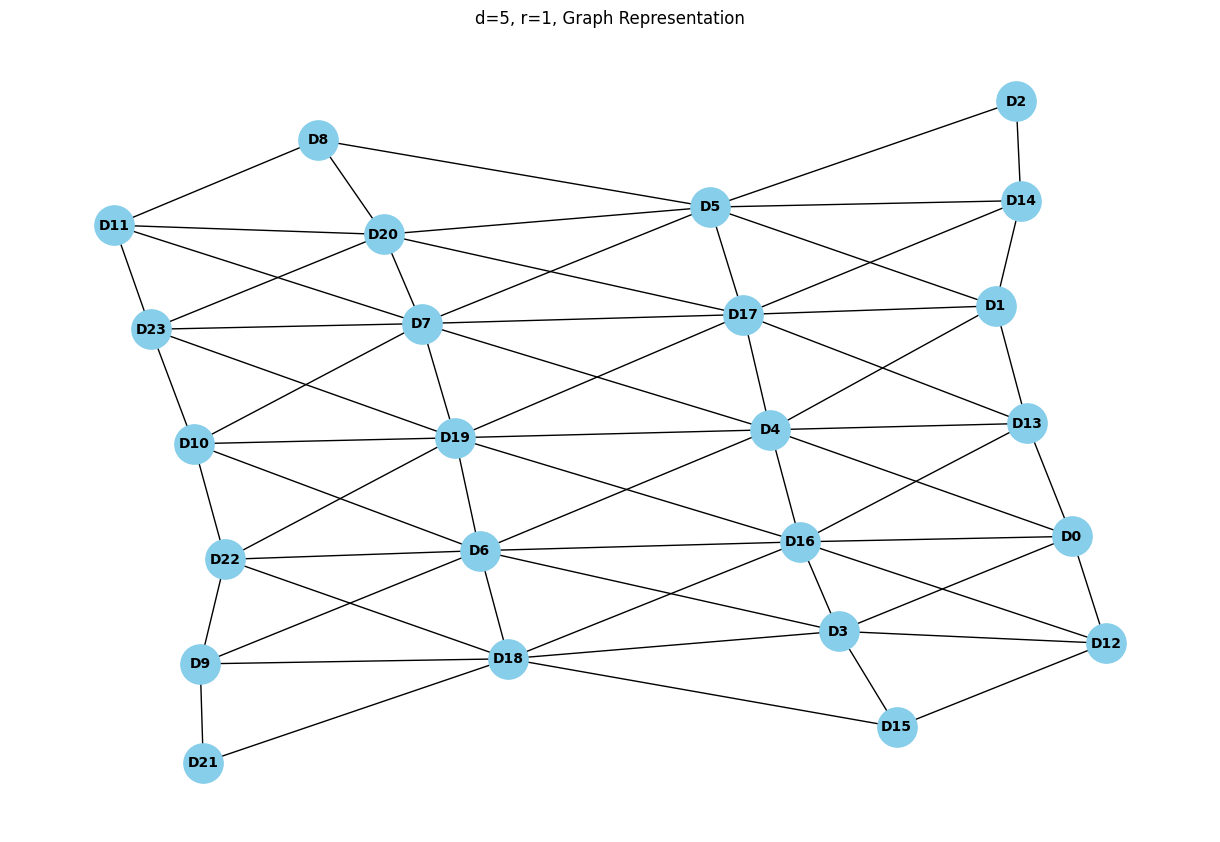

In [13]:
import logging
import matplotlib as mpl

# 设置matplotlib的日志级别为WARNING
mpl.set_loglevel('WARNING')

# 设置全局日志级别为 WARNING
logging.basicConfig(level=logging.WARNING)

import networkx as nx
import matplotlib.pyplot as plt

# 定义邻接列表
edges = detector_connectivity

# 创建图
G = nx.Graph()

# 添加边
for node, neighbors in edges.items():
    for neighbor in neighbors:
        G.add_edge(node, f'D{neighbor}')

# 绘制图
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # 使用弹簧布局
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('d=5, r=1, Graph Representation')
plt.show()

In [25]:
# G# 获取邻接矩阵
# adj_matrix = nx.adjacency_matrix(G).todense()

# # 打印邻接矩阵
# print("邻接矩阵：")
# print(adj_matrix)
# import numpy as np
# def is_symmetric(adj_matrix):
#     # 判断邻接矩阵是否是对称的
#     return np.allclose(adj_matrix, adj_matrix.T)

# # 判断是否关于某个轴对称
# if is_symmetric(adj_matrix):
#     print("图是对称的")
# else:
#     print("图不是对称的")

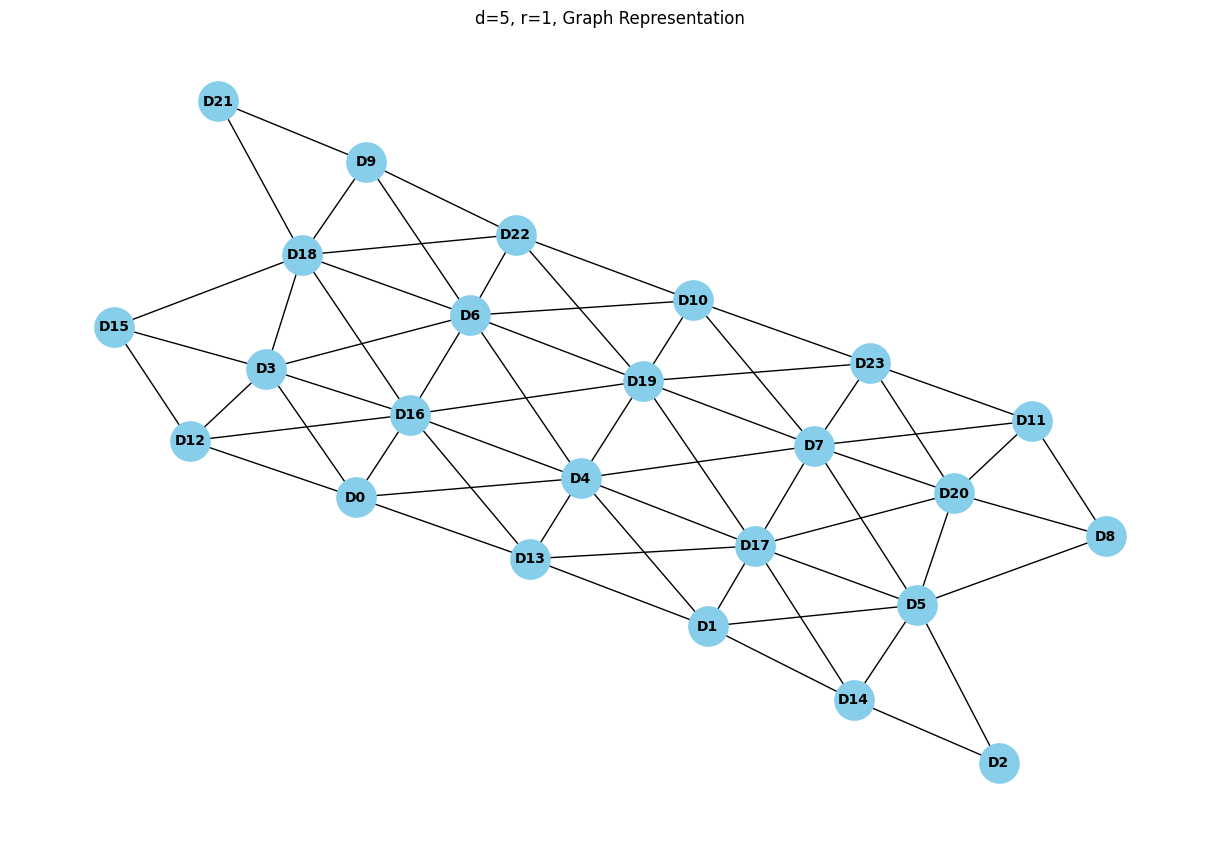

我们发现，超图的连通情况是对称的。